In [1]:
## Imports
import os, sys
import time
import yaml
import h5py
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#from cGANtools.GAN import CGAN
#from keras.models import load_model

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)
import helper as hp

### Slice of life functions

In [20]:
def load_and_generate(gen, d_scaling, ss_idx, n_samples, noise = []):
    
    sampled_labels = np.ones(n_samples).reshape(-1, 1) * cond_class  # sample conditional labels
    if len(noise)==0:
        noise = np.random.normal(0, 1, (n_samples, 127))             # generate random noise
        
    gen_par = gen.predict([noise, sampled_labels])                   # generate parameters
    
    # rescale parameters
    x_new, new_min, new_max = hp.unscale_range(gen_par, -1.0, 1.0, d_scaling['min_x'], d_scaling['max_x'])
    
    return x_new, noise

def min_2(numbers):
    # Find the index of the minimum value
    min1_index = numbers.index(min(numbers))
    
    # Temporarily replace the smallest number with a large value to find the next smallest
    temp_numbers = numbers.copy()  # Make a copy of the list
    temp_numbers[min1_index] = float('inf')  # Replace the smallest number with infinity
    
    # Find the index of the second minimum value
    min2_index = temp_numbers.index(min(temp_numbers))

    return min1_index, min2_index

### Results displayed for 1 model (Steady state 2, index 13)

In [3]:
path_to_sample = f'analysis/2/sample.npy'
sample = np.load(path_to_sample)

eigs = pd.read_csv(f'analysis/2/sample_max_eig.csv').iloc[:,1].values
valid_ix = np.where(eigs<=0)[0]

eigs = eigs[valid_ix]
sample = sample[valid_ix]

In [20]:
all_corr = []
for this_km_ix in range(259):
    corr = np.corrcoef(sample[:,this_km_ix], eigs)
    all_corr.append(corr[0][1])

plt.figure(figsize = (5,5))
plt.hist(all_corr, bins = 20)
plt.xlim([-1,1])
plt.savefig(f'global_correlation.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 93 and the array at index 1 has size 100

In [21]:
ss_idx = 2
ix = 13   

eigs = pd.read_csv(f'analysis/2/sample_max_eig.csv').iloc[:,1].values
seed_eig = eigs[ix]

path_to_max_eigs = f'analysis/{ss_idx}/km_heatmap/{ix}/max_eig.csv'
max_eigs = pd.read_csv(path_to_max_eigs).iloc[:,1].values

sorted_lst = sorted(enumerate(max_eigs), key=lambda x: (-x[1], -x[0]))
sorted_max_eigs = [x[1] for x in sorted_lst]
sorted_max_eigs_ix = [x[0] for x in sorted_lst]

n_models = 30   ## Models 

# get fastest model indexes
fastest_ixs = sorted_max_eigs_ix[-n_models:]

# get model indexes with similar eigenvalues as seed model
tolerance = 0.01
up_lim, low_lim = seed_eig*(1-tolerance), seed_eig*(1+tolerance)
moderate_ixs = [i for i, value in enumerate(max_eigs) if low_lim < value < up_lim]
print(len(moderate_ixs))

# get slowest model indexes
slowest_ixs = sorted_max_eigs_ix[:n_models]

all_ixs = []
for this_ixs in [fastest_ixs, moderate_ixs, slowest_ixs]:
    for this_ix in this_ixs: all_ixs.append(int(this_ix))

pd.DataFrame(all_ixs).to_csv(f'analysis/{ss_idx}/km_heatmap/{ix}/interesting_indexes.csv')

24


fast: percentage of valid models: 60.0
fast: time for settling: 8.64 mins
no change: percentage of valid models: 79.16666666666667
no change: time for settling: 11.92 mins
slow: percentage of valid models: 66.66666666666667
slow: time for settling: 24.93 mins


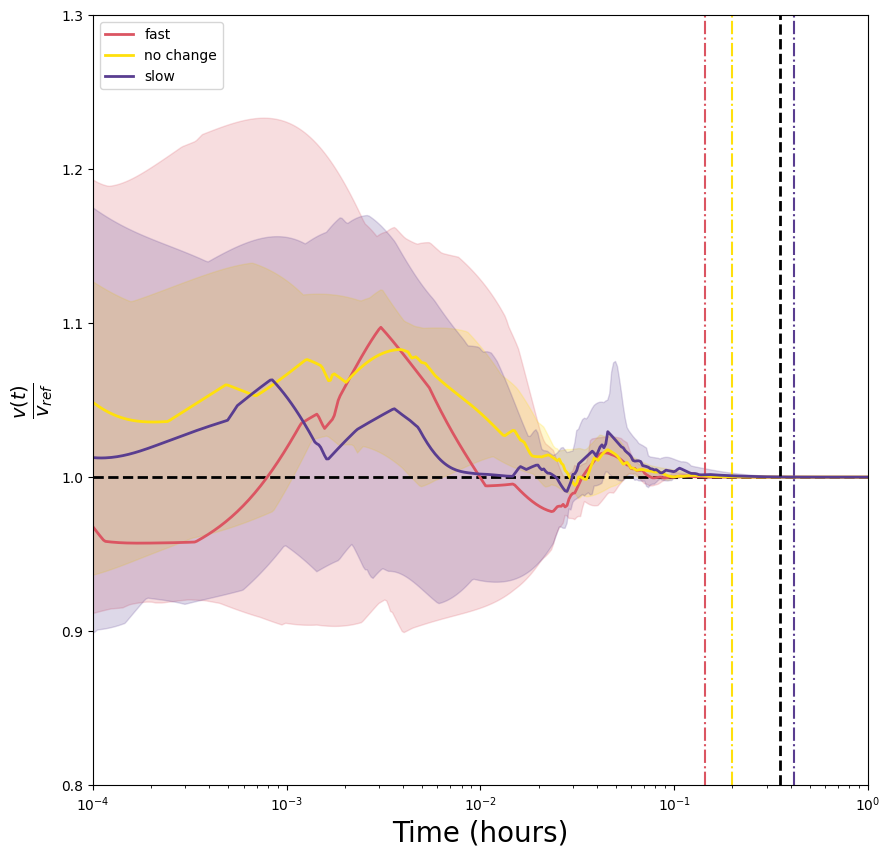

In [23]:
tol = 0.001
T = np.logspace(-9, 1, 1000)
labels = ['fast','no change','slow']
coolors = ['#DB5562', '#FFE00C', '#593D90']

plt.figure(figsize = (10,10))

plt.axhline(y = 1, ls = '--', color = 'k', lw = 2)
path_to_ode_solutions = f'analysis/{ss_idx}/km_heatmap/{ix}/ode_output/latent_heatmap_soln/'
v_ref = 0.000674332689731 # from steady state profile
for this_cool, this_label,these_ixs in zip(coolors, labels, [fastest_ixs, moderate_ixs, slowest_ixs]):
    all_biomass = []
    viable_models = 0
    for this_ix in these_ixs:
        this_solution = pd.read_csv(f'{path_to_ode_solutions}fluxes_{this_ix}.csv')
        soln = this_solution['LMPD_biomass_c_17_462'].values/v_ref
        if round(soln[-1]) == 1:
            all_biomass.append(this_solution['LMPD_biomass_c_17_462'].values/v_ref)
            #plt.plot(T, soln, color = this_cool)
            viable_models+=1
    print(f'{this_label}: percentage of valid models: {viable_models*100/len(these_ixs)}')
    all_biomass = np.array(all_biomass)
    plt.plot(T, np.median(all_biomass, axis = 0), label = this_label, c = this_cool, lw = 2)
    plt.fill_between(T,  np.percentile(all_biomass, 25, axis = 0),  np.percentile(all_biomass, 75, axis = 0), color = this_cool, alpha = 0.2)
    
    ix_max = np.where(np.max(all_biomass, axis = 0)<1+tol)[0]
    ix_min = np.where(np.min(all_biomass, axis = 0)>1-tol)[0]
    ix_for_vertical = np.intersect1d(ix_max, ix_min)[0]
    plt.axvline(T[ix_for_vertical], color = this_cool, ls = '-.')
    print(f'{this_label}: time for settling: {np.round(T[ix_for_vertical]*60,2)} mins')
plt.xscale('log')
plt.xlim([1e-4, 1])
plt.axvline(21/60, color = 'k', ls = '--', lw = 2)
plt.ylim([0.8, 1.3])
plt.xlabel(f'Time (hours)', fontsize = 20)
plt.ylabel(r'$\frac{v(t)}{v_{ref}}$', fontsize = 20)
plt.legend()

plot_path = 'figures/figure_3'

plt.savefig(f'{plot_path}/ODE_biomass_Km.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'{plot_path}/ODE_biomass_Km.png', dpi=300, transparent=False, bbox_inches='tight')

plt.show()
plt.close()

fast: percentage of valid models: 60.0
fast: time for settling: 11.13 mins
no change: percentage of valid models: 79.16666666666667
no change: time for settling: 14.67 mins
slow: percentage of valid models: 66.66666666666667
slow: time for settling: 29.3 mins


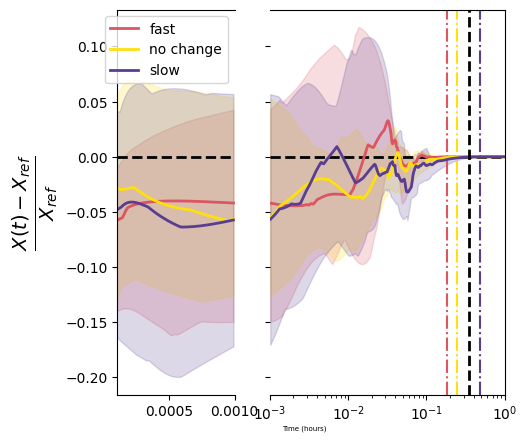

fast: percentage of valid models: 60.0
fast: time for settling: 7.35 mins
no change: percentage of valid models: 79.16666666666667
no change: time for settling: 8.25 mins
slow: percentage of valid models: 86.66666666666667
does not settle


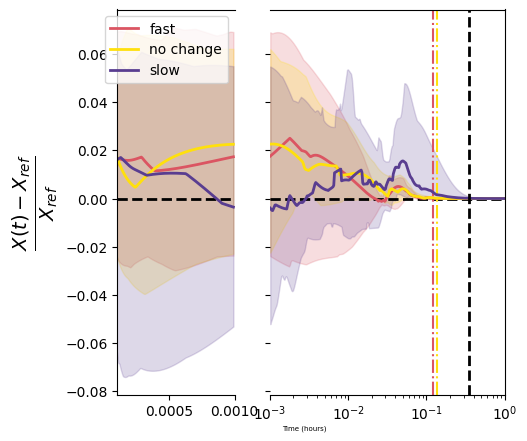

fast: percentage of valid models: 60.0
fast: time for settling: 9.25 mins
no change: percentage of valid models: 79.16666666666667
no change: time for settling: 12.78 mins
slow: percentage of valid models: 66.66666666666667
slow: time for settling: 26.72 mins


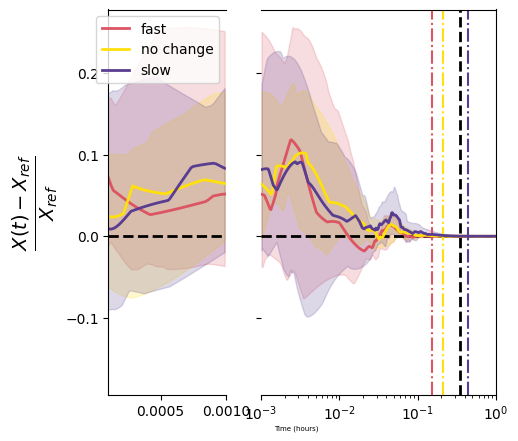

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tol = 0.001
T = np.logspace(-9, 1, 1000)  # Time points
labels = ['fast','no change','slow']
coolors = ['#DB5562', '#FFE00C', '#593D90']

refs = [-6.12818325253493, -5.64929428937213, -13.5606128668308]
ids = ['atp_c', 'adp_c', 'nadp_c']
names = ['atp', 'adp', 'nadh']

# Define the threshold for linear-to-log transition
threshold = 1e-3  # Adjust as needed

for (v_ref, met_id, label_name) in zip(refs, ids, names):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(5, 5), gridspec_kw={'width_ratios': [1, 2]})
    
    # Common horizontal line
    ax1.axhline(y=0, ls='--', color='k', lw=2)
    ax2.axhline(y=0, ls='--', color='k', lw=2)
    
    path_to_ode_solutions = f'analysis/{ss_idx}/km_heatmap/{ix}/ode_output/latent_heatmap_soln/'
    settling_time = []

    for this_cool, this_label, these_ixs in zip(coolors, labels, [fastest_ixs, moderate_ixs, slowest_ixs]):
        all_biomass = []
        viable_models = 0
        
        for this_ix in these_ixs:
            this_solution = pd.read_csv(f'{path_to_ode_solutions}solution_{this_ix}.csv')
            soln = this_solution[met_id].values
            
            if round(soln[-1]) == 0:
                all_biomass.append(soln)
                viable_models += 1
        
        print(f'{this_label}: percentage of valid models: {viable_models * 100 / len(these_ixs)}')
        
        all_biomass = np.array(all_biomass)
        
        # Split data for linear and log portions
        T_linear = T[T < threshold]
        T_log = T[T >= threshold]
        
        median_linear = np.median(all_biomass[:, T < threshold], axis=0)
        median_log = np.median(all_biomass[:, T >= threshold], axis=0)
        
        percentile_25_linear = np.percentile(all_biomass[:, T < threshold], 25, axis=0)
        percentile_75_linear = np.percentile(all_biomass[:, T < threshold], 75, axis=0)
        
        percentile_25_log = np.percentile(all_biomass[:, T >= threshold], 25, axis=0)
        percentile_75_log = np.percentile(all_biomass[:, T >= threshold], 75, axis=0)

        # Plot on linear axis
        ax1.plot(T_linear, median_linear, label=this_label, c=this_cool, lw=2)
        ax1.fill_between(T_linear, percentile_25_linear, percentile_75_linear, color=this_cool, alpha=0.2)

        # Plot on log axis
        ax2.plot(T_log, median_log, label=this_label, c=this_cool, lw=2)
        ax2.fill_between(T_log, percentile_25_log, percentile_75_log, color=this_cool, alpha=0.2)

        # Compute time for settling and draw vertical line
        ix_max = np.where(np.max(all_biomass, axis=0) < tol)[0]
        ix_min = np.where(np.min(all_biomass, axis=0) > -tol)[0]

        if ix_max.size == 0 or ix_min.size == 0:
            print('does not settle')
        else:
            ix_for_vertical = np.intersect1d(ix_max, ix_min)[0]

            if T[ix_for_vertical] < threshold:
                ax1.axvline(T[ix_for_vertical], color=this_cool, ls='-.')
            else:
                ax2.axvline(T[ix_for_vertical], color=this_cool, ls='-.')

            print(f'{this_label}: time for settling: {np.round(T[ix_for_vertical] * 60, 2)} mins')
            settling_time.append(T[ix_for_vertical])

    threshold = 1e-3 #settling_time[1]
    # Adjust x-axis scales
    ax1.set_xscale('linear')
    ax1.set_xlim([1e-4, threshold])

    ax2.set_xscale('log')
    ax2.set_xlim([threshold, 1])

    # Hide overlapping spines for a seamless transition
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # Common labels
    fig.text(0.5, 0.04, 'Time (hours)', ha='center', fontsize=5)
    ax1.set_ylabel(r'$\frac{X(t)-X_{ref}}{X_{ref}}$', fontsize=20)

    ax2.axvline(21 / 60, color='k', ls='--', lw=2)
    ax1.legend()

    # Save the figure
    plot_path = 'figures/figure_3'
    
    plt.savefig(f'{plot_path}/ODE_{label_name}_km.svg', dpi=300, transparent=False, bbox_inches='tight')
    plt.savefig(f'{plot_path}/ODE_{label_name}_km.png', dpi=300, transparent=False, bbox_inches='tight')
    
    plt.show()
    plt.close()

In [30]:
settling_time

[0.15423686462966305, 0.21297485357455231, 0.445295850994266]